# Introdução aos Ataques DDoS no Dataset CICDDoS2019

O dataset contém múltiplos cenários de ataques, registrados em arquivos CSV, com detalhes sobre tráfego malicioso e legítimo. Abaixo, são listados os períodos de tempo (em horas e minutos) em que os ataques ocorreram, organizados por dia e tipo de ataque.


## Ataques coloetados no dia (01/12)

```csv
data_path, length, columns, hour
DrDos_NTP.csv, 1217007, 88, 10:35 - 10:45
DrDos_DNS.csv, 5074413, 88, 10:52 - 11:05
DrDos_LDAP.csv, 2181542, 88, 11:22 - 11:32
DrDos_MSSQL.csv, 4524498, 88, 11:36 - 11:45
DrDos_NetBIOS.csv, 4094986, 88, 11:50 - 12:00
DrDos_SNMP.csv, 5161377, 88, 12:12 - 12:23
DrDos_SSDP.csv, 2611374, 88, 12:27 - 12:37
DrDos_UDP.csv, 3136802, 88, 12:45 - 13:09
UDPLag.csv, 370605, 88, 13:11 - 13:15
Syn.csv, 1582681, 88, 13:29 - 13:34
TFTP.csv, 20107827, 88, 13:35 - 17:15
```

## Ataques coloetados no dia (03/11)

```csv
data_path, length, columns, hour
NetBIOS.csv, 3455899, 88, 10:00 - 10:09
LDAP.csv, 2113234, 88, 10:21 - 10:30
MSSQL.csv, 5775786, 88, 10:33 - 10:42
UDP.csv, 3782206, 88,  10:53 - 11:03
UDPLag.csv, 725165, 88, 11:14 - 11:24
Syn.csv, 4320541, 88, 11:28 - 17:35
```

Portmap.csv não tem período de ataque 

# Pré-Processamento CICDDoS

In [94]:
# selected_columns = [
#     ' Source IP',
#     ' Source Port',
#     ' Destination IP',
#     ' Destination Port',
#     ' Timestamp',
#     ' Flow Duration',
#     ' Total Fwd Packets',
#     ' Total Backward Packets',
#     'Total Length of Fwd Packets',
#     ' Total Length of Bwd Packets',
#     'Flow Bytes/s',
#     ' Flow Packets/s',
#     'Fwd Packets/s',
#     ' Bwd Packets/s',
# ]

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import os

class DatasetBuilder:
    def criar_dataset_realista_para_lstm(self, path_normal, path_ataques, output_path,
                                         nome_saida="dataset_treino.csv",
                                         proporcao_ataques=0.4,
                                         tamanho_janela=50):
    
        # Carregar os datasets
        df_normal = pd.read_csv(path_normal, sep=';')
        df_ataques = pd.read_csv(path_ataques, sep=';')

        # Embaralhar os dados para garantir aleatoriedade
        df_normal = shuffle(df_normal, random_state=42)
        df_ataques = shuffle(df_ataques, random_state=42)

        # Calcular proporções reais dos ataques
        total_atasques = len(df_ataques)
        proporcao_real_ataques = min(proporcao_ataques, total_atasques / len(df_normal))

        # Criar janelas de tráfego misturado
        dataset = []
        idx_ataque = 0

        for i in range(0, len(df_normal), tamanho_janela):
            # Janela de tráfego normal
            janela_normal = df_normal.iloc[i:i+tamanho_janela]
            dataset.append(janela_normal)

            # Adicionar ataques aleatórios nesta janela
            qtd_ataques = min(int(proporcao_real_ataques * tamanho_janela),
                              len(df_ataques) - idx_ataque)
            
            if qtd_ataques > 0:
                janela_ataques = df_ataques.iloc[idx_ataque:idx_ataque+qtd_ataques]
                dataset.append(janela_ataques)
                idx_ataque += qtd_ataques

        # Junta todas as janelas
        df_final = pd.concat(dataset).reset_index(drop=True)

        # Embaralhar o dataset final para misturar janelas
        df_final = shuffle(df_final, random_state=42)

        # Salvar o dataset
        os.makedirs(output_path, exist_ok=True)
        saida_csv = os.path.join(output_path, nome_saida)
        df_final.to_csv(saida_csv, sep=';', index=False)

        return saida_csv




In [95]:
builder = DatasetBuilder()
caminho_saida = builder.criar_dataset_realista_para_lstm(
    path_ataques="data/cic_puro/treino_ataque_ordenado.csv",
    path_normal="data/cic_puro/treino_sem_ataque_ordenado.csv",
    output_path="data/cic_puro",
    nome_saida="dataset_treino.csv",
    proporcao_ataques=0.4,  # Máximo de 40% de ataques no dataset
    tamanho_janela=50       # Tamanho da janela de tráfego normal
)


In [96]:
builder = DatasetBuilder()
caminho_saida = builder.criar_dataset_realista_para_lstm(
    path_ataques="data/cic_puro/teste_ataque_ordenado.csv",
    path_normal="data/cic_puro/teste_sem_ataque_ordenado.csv",
    output_path="data/cic_puro",
    nome_saida="dataset_teste.csv",
    proporcao_ataques=0.4,  # Máximo de 40% de ataques no dataset
    tamanho_janela=50       # Tamanho da janela de tráfego normal
)

## Análise de correlação - TESTE

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def analyze_rfe_feature_importance(file_path, label_column='label', top_k=15, sample_frac=1.0, random_state=42):
    df = pd.read_csv(file_path)

    # Amostragem dos dados
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)

    # Salvar colunas categóricas (ex: IPs)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    preserved_cols = df[categorical_cols]

    # Limpar dados
    df.dropna(axis=1, how='all', inplace=True)  # remove colunas 100% nulas

    # Trabalhar só com numéricas
    df_numeric = df.select_dtypes(include=['number'])

    if label_column not in df_numeric.columns:
        raise ValueError(f"Coluna '{label_column}' não encontrada no dataset.")

    # X e y
    X = df_numeric.drop(columns=[label_column])
    y = df_numeric[label_column]

    # Remover infs e nulos
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    y = y.loc[X.index]
    preserved_cols = preserved_cols.loc[X.index]

    # Normalização (opcional para RF, mas ajuda no desempenho)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Estimador
    estimator = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # RFE com o número de features que queremos ranquear
    rfe = RFE(estimator=estimator, n_features_to_select=top_k)
    rfe.fit(X_scaled, y)

    # Obter os nomes das colunas selecionadas
    selected_features = X.columns[rfe.support_]
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)

    # Plotar as top features selecionadas
    top_features = feature_ranking[feature_ranking == 1].index
    importances = estimator.fit(X, y).feature_importances_
    importance_series = pd.Series(importances, index=X.columns).loc[top_features]

    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_series.values, y=importance_series.index, palette='magma')
    plt.title(f'Top {top_k} Features Relevantes (RFE + Random Forest)')
    plt.xlabel("Importância")
    plt.tight_layout()
    plt.show()

    return top_features, preserved_cols


C:\Users\leand\AppData\Local\Temp\ipykernel_7220\1409141344.py:12: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\leand\AppData\Local\Temp\ipykernel_7220\1409141344.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_series.values, y=importance_series.index, palette='magma')


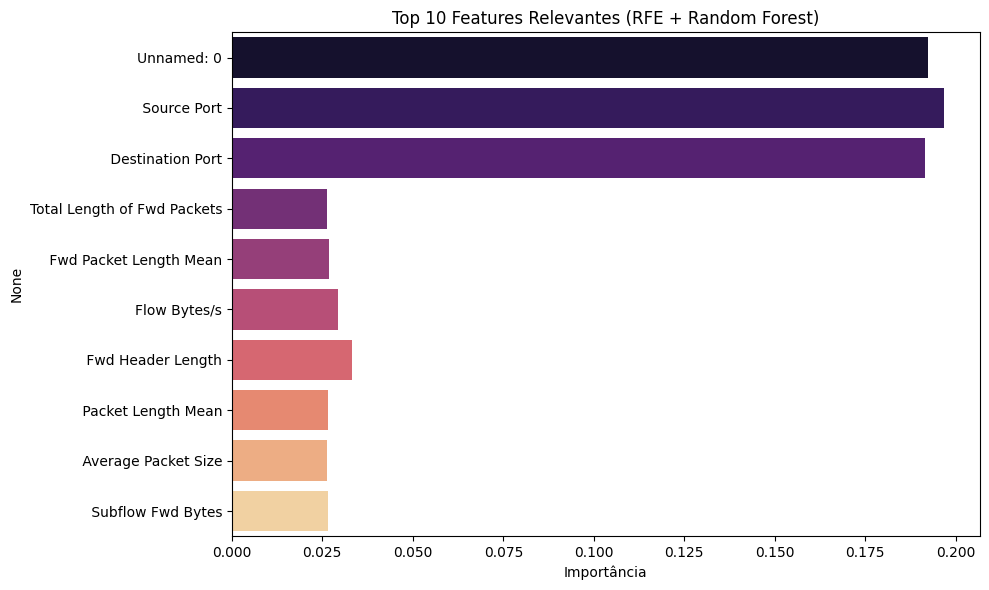

In [35]:
top_rfe_features, preserved_data = analyze_rfe_feature_importance(
    data_path_2day + "/DrDos_MSSQL_labeled.csv",
    top_k=10,
    sample_frac=0.01  
)



## LSTM

In [441]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [447]:
class SequenceDataset(Dataset):
    def __init__(self, path, sequence_length, column_to_remove=None):
        df = pd.read_csv(path, sep=';')

        if column_to_remove and column_to_remove in df.columns:
            df = df.drop(columns=[column_to_remove])

        # Separar features e labels
        features = df.iloc[:, :-1].values  # Assume que a última coluna é a label
        labels = df.iloc[:, -1].values

        # Normalizar os dados 
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        # Criar sequências
        sequences = []
        sequence_labels = []
        for i in range(len(features) - sequence_length + 1):
            seq = features[i:i+sequence_length]
            label = labels[i+sequence_length-1]  
            sequences.append(seq)
            sequence_labels.append(label)

        # Converter para tensores
        self.sequences = torch.tensor(sequences, dtype=torch.float32).view(-1, sequence_length, features.shape[1])
        self.labels = torch.tensor(sequence_labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

In [452]:
# Configurar os parâmetros da rede LSTM
input_size = 9         # Número de features no dataset / Tamanho do vetor de entrada por tempo
hidden_size = 64       # Tamanho do hidden state / Nº de unidades ocultas por célula
num_layers = 2         # Número de camadas LSTM / Nº de camadas LSTM empilhadas
output_size = 2        # Classes: normal (0), anomalia (1) 
batch_size = 128        # Batch size / 
num_epochs = 60         # Número de epochs
lr = 0.001             # Learning rate
sequence_length = 1   # Tamanho da sequência de entrada para a LSTM
column_to_remove = 'attack_name'  # Coluna a ser removida


In [453]:
# Criar os datasets
train_dataset = SequenceDataset('data/cic_puro/dataset_treino.csv', sequence_length, column_to_remove)
test_dataset = SequenceDataset('data/cic_puro/dataset_teste.csv', sequence_length, column_to_remove)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Formato dos loaders
for batch in train_loader:
    inputs, labels = batch
    print(f"Train Loader - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

for batch in test_loader:
    inputs, labels = batch
    print(f"Test Loader - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

Train Loader - Inputs shape: torch.Size([128, 1, 9]), Labels shape: torch.Size([128])
Test Loader - Inputs shape: torch.Size([128, 1, 9]), Labels shape: torch.Size([128])


In [454]:
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Primeira camada LSTM
        self.lstm1 = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True
                             )
        
        # Segunda camada LSTM
        self.lstm2 = nn.LSTM(input_size=hidden_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True                             
                            )
        
        self.lstm3 = nn.LSTM(input_size=hidden_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True
                             )
        
        # Camada fully-connected
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
        # Camada de ativação softmax
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)  # Primeira camada LSTM
        out, _ = self.lstm2(out)  # Segunda camada LSTM
        out, _ = self.lstm3(out)  # Terceira camada LSTM 
        out = self.fc(out[:, -1, :])  # Usar a última saída do LSTM como entrada para fc
        out = self.softmax(out)  # Aplicar softmax para obter probabilidades
        
        return out
    
    def save_model(self, filename):
        torch.save(self.state_dict(), filename)
        print(f"Modelo salvo em: {filename}")


# out = self.dropout(out)  # Aplicar dropout se necessário
# out = self.batch_norm(out)  # Aplicar batch normalization se necessário
# out = self.relu(out)  # Aplicar ReLU se necessário
# out = self.tanh(out)  # Aplicar Tanh se necessário
# out = self.sigmoid(out)  # Aplicar Sigmoid se necessário
# out = self.leaky_relu(out)  # Aplicar Leaky ReLU se necessário
# out = self.prelu(out)  # Aplicar PReLU se necessário
# out = self.elu(out)  # Aplicar ELU se necessário
        

In [ ]:
# Criar o modelo
model = LSTM_model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
print(model)

# Testar a dimensão da entrada e saída do modelo
x, y = next(iter(train_loader))  
output = model(x)
print(f"Dimensão da entrada: {x.size()}")   # shape: [batch_size, sequence_length, input_size]
print(f"Dimensão da saída: {y.size()}")    # shape: [batch_size]
print(f"Dimensão da saída do modelo: {output.size()}") # shape: [batch_size, output_size]

# ======== Funções de perda ========
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss: Para classificação multi-classe (softmax já incluído)
criterion = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss: Para classificação binária (já inclui sigmoid)
criterion = nn.BCELoss() # BCELoss: Para classificação binária (usa sigmoid manual)
criterion = nn.MSELoss() # MSELoss: Erro quadrático médio, útil para regressão
criterion = nn.L1Loss() # L1Loss: Erro absoluto médio (mais robusto a outliers)
criterion = nn.SmoothL1Loss() # SmoothL1Loss: Combina MSE e L1, também chamada de Huber Loss
criterion = nn.MarginRankingLoss() # MarginRankingLoss: Para tarefas de ranking (como ver qual entrada é “maior”)
criterion = nn.HingeEmbeddingLoss() # HingeEmbeddingLoss: Usado em tarefas de classificação com embeddings

# ========== Otimizadores ==========
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam: muito usado, bom para a maioria dos casos
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # SGD: gradiente descendente padrão, pode usar momentum
optimizer = optim.RMSprop(model.parameters(), lr=lr) # RMSprop: bom para dados sequenciais e LSTM
optimizer = optim.Adagrad(model.parameters(), lr=lr) # Adagrad: bom para dados esparsos (ex: NLP)
optimizer = optim.AdamW(model.parameters(), lr=lr) # AdamW: versão do Adam com regularização corrigida (recomendado para Transformers)
optimizer = optim.Adadelta(model.parameters(), lr=lr) # Adadelta: adapta o learning rate dinamicamente
optimizer = optim.NAdam(model.parameters(), lr=lr) # Nadam: Adam + Nesterov momentum

# Treinamento do modelo
best_loss = float('inf') # Inicializa a melhor perda como infinito
for epoch in range(num_epochs):
    # Treinamento
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.permute(0, 1, 2)
        optimizer.zero_grad()
        outputs = model(inputs)       
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    
    # Validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 1, 2)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels).item()
    
    avg_val_loss = val_loss / len(test_loader)

    # Calcular a acurácia
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 1, 2)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    acc = accuracy_score(y_true, y_pred)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {acc:.4f}')
    
    # Salvar o melhor modelo
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')
        print('Melhor modelo salvo!')

LSTM_model(
  (lstm1): LSTM(9, 64, num_layers=2, batch_first=True)
  (lstm2): LSTM(64, 64, num_layers=2, batch_first=True)
  (lstm3): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
Dimensão da entrada: torch.Size([128, 1, 9])
Dimensão da saída: torch.Size([128])
Dimensão da saída do modelo: torch.Size([128, 2])
Epoch [1/60], Loss: 0.4957, Val Loss: 0.5328, Accuracy: 0.7972
Melhor modelo salvo!
Epoch [2/60], Loss: 0.4360, Val Loss: 0.5108, Accuracy: 0.7991
Melhor modelo salvo!
Epoch [3/60], Loss: 0.3941, Val Loss: 0.5041, Accuracy: 0.8054
Melhor modelo salvo!
Epoch [4/60], Loss: 0.4930, Val Loss: 0.5068, Accuracy: 0.8053
Epoch [5/60], Loss: 0.3535, Val Loss: 0.5101, Accuracy: 0.8006
Epoch [6/60], Loss: 0.3803, Val Loss: 0.4947, Accuracy: 0.8175
Melhor modelo salvo!
Epoch [7/60], Loss: 0.4971, Val Loss: 0.5123, Accuracy: 0.7992
Epoch [8/60], Loss: 0.5133, Val Loss: 0.5014, Accuracy: 0.8111
Epoch [9/60],

## CNN

In [19]:
# 📦 CÉLULA 1 – IMPORTAÇÕES E CONFIGURAÇÕES
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo em uso: {device}")


Dispositivo em uso: cuda


In [20]:
# 📄 CÉLULA 2 – DATASET COM REMOÇÃO DE COLUNA E DIVISÃO EM SEQUÊNCIAS
class SequenceDataset(Dataset):
    def __init__(self, path, sequence_length, column_to_remove=None):
        df = pd.read_csv(path)

        # Remover coluna opcional (como timestamp ou id)
        if column_to_remove and column_to_remove in df.columns:
            df = df.drop(columns=[column_to_remove])

        # Separar features e labels
        data = df.drop(columns=['label']).values
        labels = df['label'].values

        self.sequences = []
        self.labels = []

        for i in range(len(data) - sequence_length + 1):
            self.sequences.append(data[i:i+sequence_length])
            self.labels.append(labels[i+sequence_length-1])

        # Formato final: (batch, channels=1, time_steps)
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [21]:
# 🧠 CÉLULA 3 – DEFINIÇÃO DO MODELO CNN 1D
class CNN1DNet(nn.Module):
    def __init__(self, input_length, output_size=2):
        super(CNN1DNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Flatten(),
            nn.Linear((input_length // 4) * 64, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
sequence_length = 20
input_size = 9     
output_size = 2
batch_size = 32
num_epochs = 20
lr = 0.001
column_to_remove = 'attack_name'

train_dataset = SequenceDataset('data/cic_puro_enhanced/01-12-train.csv', sequence_length, column_to_remove)
test_dataset  = SequenceDataset('data/cic_puro_enhanced/03-11-test.csv', sequence_length, column_to_remove)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
model = CNN1DNet(input_length=sequence_length, output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 🔍 Validação
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1).cpu()
            y_pred.extend(predicted.numpy())
            y_true.extend(y_batch.numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Época {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print("✅ Novo melhor modelo salvo com accuracy:", best_accuracy)


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 1, 20, 9]

## LSTM-CNN-SVM

In [ ]:
class CNN_LSTM_model(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2, output_size=2):
        super(CNN_LSTM_model, self).__init__()
        
        # Camada CNN para extrair características locais
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Camada LSTM
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        # Camada全连接 após a LSTM
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # A CNN espera (batch_size, channels, sequence_length), então precisamos transpor
        x = x.permute(0, 2, 1)  # [batch_size, seq_length, input_size] -> [batch_size, input_size, seq_length]
        
        out = self.cnn(x)
        out = out.permute(0, 2, 1)  # Volta para [batch_size, sequence_length, channels]
        
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])  # Pega o último timestep
        return out


# Backup 

## 1 - Abrir aquivo e fazer o plot

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

data_path = os.path.join("data", "01-12")
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]

selected_columns = [
    "Flow ID", " Source IP", " Source Port", " Destination IP", 
    " Destination Port", " Protocol", " Timestamp", " Flow Duration",
    " Total Fwd Packets"
]

for file_name in csv_files:
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, usecols=selected_columns)
    plt.figure(figsize=(10, 5))
    df["Timestamp"] = pd.to_datetime(df[" Timestamp"], errors="coerce")
    df = df.dropna(subset=["Timestamp"])
    
    plt.plot(df["Timestamp"], df[" Total Fwd Packets"], label="Total Fwd Packets", color="blue")
    plt.xlabel("Tempo")
    plt.ylabel("Pacotes Enviados")
    plt.title(f"Tráfego de Pacotes - {file_name}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
